# **Artificial Intelligence Final Project**

* Ingrid Edith Martínez Andrade 1995361
* Pablo Emiliano Martinez Perez 2003785
* Andrea Mayela Santos García   1948005
* Alejandra Sepúlveda Rojas     2017856



A brain tumor is a collection, or mass, of abnormal cells in your brain. Your skull, which encloses your brain, is very rigid. Any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening.



This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary. No tumor class images were taken from the Br35H dataset.

## **Libraries**

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
!pip install kaggle

##**Data load**


In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
#descarga from kaggle

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
zipfile_path= '/content/brain-tumor-mri-dataset.zip'

In [5]:
extract_path = '/content/Dataset' # it extracts on collab with the name of Dataset

In [6]:
with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

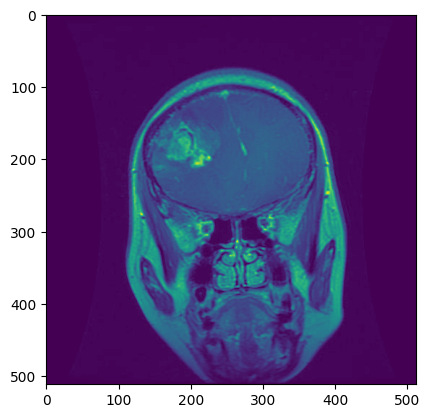

In [7]:
#img preview, using the first img of de dataset
first_train_image = cv2.imread('/content/Dataset/Training/glioma/Tr-glTr_0000.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(first_train_image)

In [8]:
datatrainingImgs = '/content/Dataset/Testing'
datatestingImgs= '/content/Dataset/Training'

In [9]:
# Image directories
glioma_train = '/content/Dataset/Training/glioma'
meningioma_train = '/content/Dataset/Training/meningioma'
notumor_train = '/content/Dataset/Training/notumor'
pituitary_train = '/content/Dataset/Training/pituitary'

glioma_test = '/content/Dataset/Testing/glioma'
meningioma_test = '/content/Dataset/Testing/meningioma'
notumor_test = '/content/Dataset/Testing/notumor'
pituitary_test = '/content/Dataset/Testing/pituitary'

dir_train = [glioma_train, meningioma_train, notumor_train, pituitary_train]
dir_test = [glioma_test, meningioma_test, notumor_test, pituitary_test]

## **Preprocessing**

**Image preprocessing**

In this case we are going to resize and normalize the images of our dataset, as shown next for a single image.

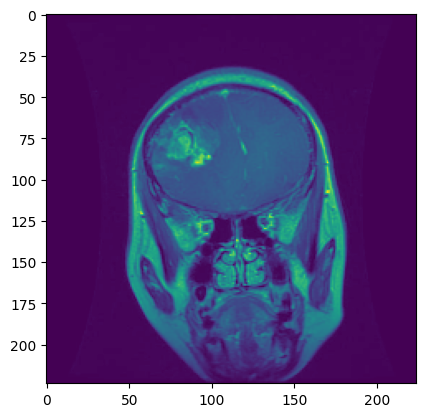

In [10]:
img_resized = cv2.resize(first_train_image, (224,224)) #escalar
img_resized = img_resized/255.0 #normalizar
plt.imshow(img_resized)

In [11]:
def check_resolutions(data_dir):
    resolutions = {"min_width": float('inf'), "min_height": float('inf'),
                   "max_width": 0, "max_height": 0}
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    h, w = img.shape[:2]
                    resolutions["min_width"] = min(resolutions["min_width"], w)
                    resolutions["min_height"] = min(resolutions["min_height"], h)
                    resolutions["max_width"] = max(resolutions["max_width"], w)
                    resolutions["max_height"] = max(resolutions["max_height"], h)
    return resolutions

train_resolutions = check_resolutions(datatrainingImgs)
test_resolutions = check_resolutions(datatestingImgs)
print("Train resolutions:", train_resolutions)
print("Test resolutions:", test_resolutions)

Train resolutions: {'min_width': 150, 'min_height': 168, 'max_width': 1149, 'max_height': 1019}
Test resolutions: {'min_width': 150, 'min_height': 168, 'max_width': 1920, 'max_height': 1446}


In [12]:
def process_and_save_images(directories, output_csv, output_numpy):

    data = []  # Lista para almacenar los datos del CSV
    images = []  # Lista para almacenar las imágenes como arrays NumPy

    for directory in directories:
        # Etiqueta basada en el nombre del subdirectorio
        label = os.path.basename(directory)

        # Verifica que el directorio exista
        if not os.path.exists(directory):
            print(f"El directorio {directory} no existe. Saltando...")
            continue

        # Iterar sobre cada archivo en el directorio
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)

            # Verifica que sea una imagen (por extensión)
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                try:
                    # Cargar imagen
                    img = cv2.imread(file_path)

                    # Verificar que la imagen se haya cargado correctamente
                    if img is None:
                        print(f"No se pudo cargar la imagen {file_path}. Saltando...")
                        continue

                    # Procesar la imagen
                    img_resized = cv2.resize(img, (224, 224))

                    # Guardar la imagen procesada en la misma ruta
                    cv2.imwrite(file_path, img_resized)

                    # Agregar datos al CSV
                    data.append({"filename": filename, "label": label})

                    # Agregar la imagen procesada al arreglo
                    images.append(img_resized)

                except Exception as e:
                    print(f"Error al procesar la imagen {file_path}: {e}")
            else:
                print(f"El archivo {filename} no es una imagen válida. Saltando...")

    # Crear DataFrame y guardar como CSV
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Procesamiento completado. CSV guardado en: {output_csv}")

    # Convertir la lista de imágenes a un array NumPy y guardar
    X_train = np.array(images)
    np.save(output_numpy, X_train)
    print(f"Arreglo NumPy de imágenes guardado en: {output_numpy}")



In [13]:
train_dirs = [ glioma_train, meningioma_train, notumor_train, pituitary_train]
# Procesar imágenes de entrenamiento y guardar CSV
process_and_save_images(train_dirs, '/content/training_data.csv', 'X_train.npy')


Procesamiento completado. CSV guardado en: /content/training_data.csv
Arreglo NumPy de imágenes guardado en: X_train.npy


In [14]:
test_dirs = [glioma_test, meningioma_test, notumor_test, pituitary_test]
# Procesar imágenes de prueba y guardar CSV
process_and_save_images(test_dirs, '/content/testing_data.csv','X_test.npy')

Procesamiento completado. CSV guardado en: /content/testing_data.csv
Arreglo NumPy de imágenes guardado en: X_test.npy


**Labels preprocessing**

Access and visualization to the np array and csv created

In [15]:
X_train = np.load('/content/X_train.npy')
X_test = np.load('/content/X_test.npy')

In [16]:
df_train = pd.read_csv('/content/training_data.csv')
df_test = pd.read_csv('/content/testing_data.csv')

In [17]:
df_train.head(10)

,filename,label
0,Tr-gl_1248.jpg,glioma
1,Tr-gl_0416.jpg,glioma
2,Tr-gl_0619.jpg,glioma
3,Tr-gl_0329.jpg,glioma
4,Tr-gl_0055.jpg,glioma
5,Tr-gl_1251.jpg,glioma
6,Tr-gl_0601.jpg,glioma
7,Tr-gl_1198.jpg,glioma
8,Tr-gl_0927.jpg,glioma
9,Tr-gl_0766.jpg,glioma


In [18]:
df_test.head()

,filename,label
0,Te-gl_0289.jpg,glioma
1,Te-gl_0295.jpg,glioma
2,Te-gl_0167.jpg,glioma
3,Te-gl_0237.jpg,glioma
4,Te-gl_0084.jpg,glioma



Making sure that the number of labels are proportional to have a good performance in our model

In [19]:
label_train = df_train['label']
label_test = df_test['label']

In [20]:
df_train['label'].value_counts()

,count
label,
notumor,1595
pituitary,1457
meningioma,1339
glioma,1321


In [21]:
df_test['label'].value_counts()

,count
label,
notumor,405
meningioma,306
glioma,300
pituitary,300


For running our model we need to have the labels as the form of numerical labels, therefore we are using LabelEncoder to make it as an array

In [22]:
# Convert string labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
label_train_encoded = label_encoder.fit_transform(label_train)
label_test_encoded = label_encoder.transform(label_test)

# One-hot encode the labels:
label_train_encoded = to_categorical(label_train_encoded)
label_test_encoded = to_categorical(label_test_encoded)


In [23]:
print(label_train_encoded)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [24]:
print(label_test_encoded)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [25]:
label_train_encoded.shape

(5712, 4)

In [26]:
label_test_encoded.shape

(1311, 4)

In [27]:
X_train.shape

(5712, 224, 224, 3)

In [28]:
X_test.shape

(1311, 224, 224, 3)

## **Model selection and training**

The architecture that has been implemented is a Custom CNN, and does not exactly follow any known architecture such as VGG, ResNet or AlexNet, but has some similarities with basic models such as VGG in terms of flow and hierarchical layer structure.



In [29]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=1000, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=800, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=500, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=4, activation="softmax")) # In this case, we have 4 categories as output

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64896)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │      64,897,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 800)                 │         800,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │         400,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,175,088 (252.44 MB)

 Trainable params: 66,175,088 (252.44 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the model using encoded labels
history = model.fit(X_train, label_train_encoded, epochs=15, batch_size=32, validation_data=(X_test, label_test_encoded))

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.5816 - loss: 39.5163 - val_accuracy: 0.8459 - val_loss: 0.4276
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8954 - loss: 0.3062 - val_accuracy: 0.8749 - val_loss: 0.3223
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9274 - loss: 0.2253 - val_accuracy: 0.8932 - val_loss: 0.2872
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9527 - loss: 0.1546 - val_accuracy: 0.9275 - val_loss: 0.2184
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9668 - loss: 0.0972 - val_accuracy: 0.9458 - val_loss: 0.1852
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9718 - loss: 0.0915 - val_accuracy: 0.9314 - val_loss: 0.2490
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9850 - loss: 0.0528 - val_accuracy: 0.9336 - val_loss: 0.3087
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9868 - loss: 0.0511 

 **Acuraccy Results**

In [32]:
# Results
test_loss, test_acc = model.evaluate(X_test, label_test_encoded)
print(f'Accuracy: {test_acc}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9212 - loss: 0.5988
Accuracy: 0.9542334079742432


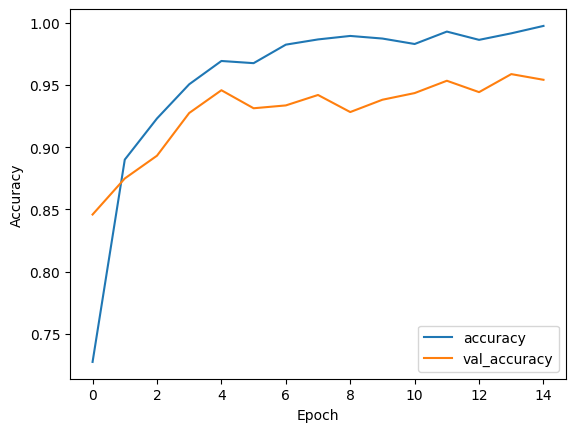

In [43]:
# accuracy plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

**Model Predictions**

In [31]:
predictions = model.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [36]:
x = predictions[0]
y = label_test_encoded[0]
print("la red dice que la imagen es:", np.argmax(x))
print("la imagen real es:", np.argmax(y))

la red dice que la imagen es: 0
la imagen real es: 0


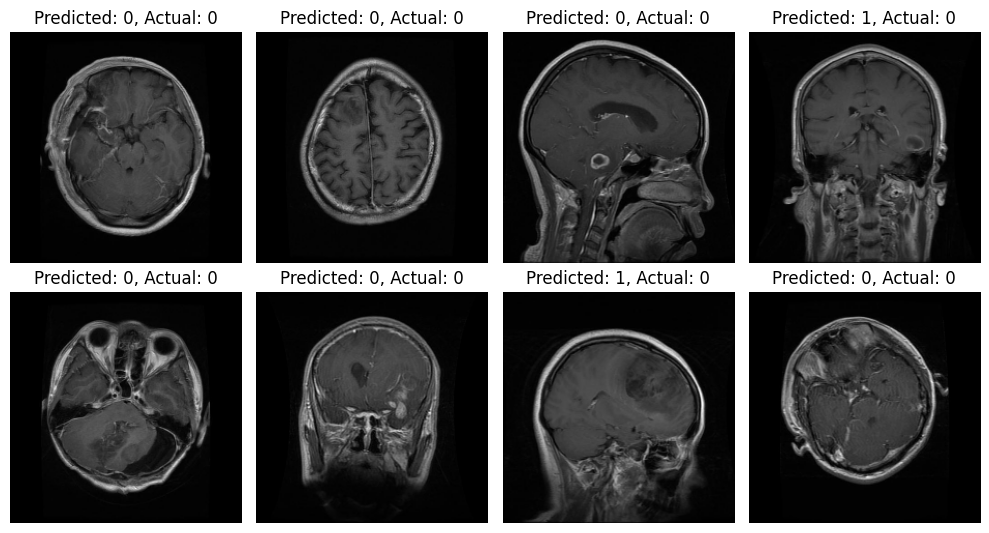

In [39]:
num_images = 8
plt.figure(figsize=(10, 8))
for i in range(num_images):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Predicted: {np.argmax(predictions[i])}, Actual: {np.argmax(label_test_encoded[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()